# Inventory Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import torch
import lropt
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":12,
    "font.family": "serif"
})

In [2]:
T = 36
torch.set_default_dtype(torch.double)
K = 1
c = torch.tensor([(1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])*0.1
p = torch.tensor(c*2.5)
h = torch.tensor(c*1.2)
c = torch.hstack([c,torch.zeros(K-1)])
p = torch.hstack([p,torch.zeros(K-1)])
h = torch.hstack([h,torch.zeros(K-1)])
d_star = np.array([1000 * (1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])
# d_star = 1000*np.ones(T)
d_star_cat = torch.hstack([torch.tensor(d_star),torch.zeros(K)])
proportion = 0.1
lhs = np.concatenate((np.eye(T), -np.eye(T)), axis=0)    
rhs_upper = (1 + proportion) * d_star
rhs_lower = (-1 + proportion) * d_star
rhs = np.hstack((rhs_upper, rhs_lower))
init_eps = 2
cov = 2000*np.eye(T)
Qmax = 3000
Vmin = -1000
Vmax = 12000
alpha1 = 0.
alpha2 = 0.
beta1 = 1
beta2 = 2
init_size = 100
demand_dist = torch.distributions.MultivariateNormal(torch.tensor(d_star),torch.tensor(cov))
cov = sc.linalg.sqrtm(cov)
torch.manual_seed(100)
sample_val = demand_dist.sample((100,))
# cov = sc.linalg.sqrtm(np.cov(sample_val.T))
init_dist = torch.distributions.Uniform(low = 0, high = 100)
eye_concat = np.eye(T+K-1)
eye_concat[T:,T:] = 0
t_vals = torch.tensor(np.arange(T))
ones = np.ones(T)
zeros = np.zeros(T)
# et_vals = torch.tensor(np.array([np.concatenate([ones[:t+1], zeros[t+1:]]) for t in range(T)]))
def plot_inventory_levels(ax, low_values, mid_values, high_values,random_values,rho):
    ax.plot(range(0, T + 1), low_values, label='Disturbance Lower Bound', color='blue', linestyle='--')
    ax.plot(range(0, T + 1), mid_values, label='Nominal Disturbance', color='green', linestyle='-')
    ax.plot(range(0, T + 1), high_values, label='Disturbance Upper Bound', color='red', linestyle='--')
    ax.plot(range(0, T + 1), random_values, label='Random Trajectory', color='orange', linestyle='--')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Inventory Level')
    ax.set_title(f'Inventory Level Over Time\nrho = {rho}')
    ax.legend()
    ax.grid(True)

In [3]:
d = cp.Variable(T)
cons = [cp.norm(d,2) <= 200]
prob = cp.Problem(objective = cp.Minimize(cp.sum((cov@d + d_star)[5:9])), constraints = cons)
prob.solve()
d.value, (cov@d + d_star).value

(array([  -0.,   -0.,   -0.,   -0.,   -0., -100., -100., -100., -100.,
          -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,
          -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,
          -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.,   -0.]),
 array([ 1000.        ,  1086.82408883,  1171.01007166,  1250.        ,
         1321.39380484, -3089.11373344, -3039.12325311, -3002.28964461,
        -2979.73207849,  1500.        ,  1492.40387651,  1469.84631039,
         1433.01270189,  1383.02222156,  1321.39380484,  1250.        ,
         1171.01007166,  1086.82408883,  1000.        ,   913.17591117,
          828.98992834,   750.        ,   678.60619516,   616.97777844,
          566.98729811,   530.15368961,   507.59612349,   500.        ,
          507.59612349,   530.15368961,   566.98729811,   616.97777844,
          678.60619516,   750.        ,   828.98992834,   913.17591117]))

## Baseline

In [4]:
def baseline_problem(x_init, cval, pval, hval):
    d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=init_eps,c = lhs, d = rhs, a = cov, b = d_star))
    # d = d_star
    q = cp.Variable(T)
    y = cp.Variable(T)
    u = cp.Variable(T)
    z = cp.Variable(T-1)
    w = cp.Variable(T)

    objective = cval@q + cp.sum(y) + cp.sum(u) + cp.sum(z)
    constraints = [0 <= q,
                q <= Qmax]
    for time in range(T):
        constraints +=[Vmin <= x_init + cp.sum(q[:time+1]) - cp.sum(d[:(time+1)]) ]
        constraints +=[x_init + cp.sum(q[:(time+1)]) - cp.sum(d[:(time+1)])<= Vmax]
        constraints += [y[time] >= hval[time]*x_init + hval[time]*cp.sum(q[:(time+1)]) - hval[time]*cp.sum(d[:(time+1)]) ]
        constraints += [y[time] >= -pval[time]*x_init - pval[time]*cp.sum(q[:(time+1)]) + pval[time]*cp.sum(d[:(time+1)]) ]
    constraints += [u >= alpha1*(q -w)]
    constraints += [u >= alpha2*(w-q)]
    constraints += [z >= beta1*(w[1:] - w[:-1])]
    constraints += [z >= beta2*(w[:-1] - w[1:])]
    prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
    prob.solve()
    return prob.objective.value, w.value, q.value, y.value, u.value, z.value


objval1, wval1, qval1, yval1, uval1, zval1 = baseline_problem(x_init = 100, cval=c[:T].detach().numpy(), pval=p[:T].detach().numpy(), hval = h[:T].detach().numpy())

6008.444518995961 6008.444518995961


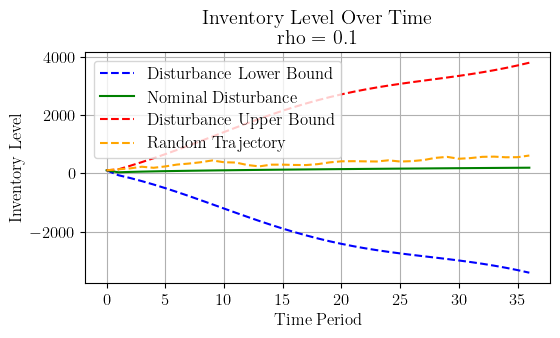

In [5]:
x_init = 100
low_values = [x_init]
mid_values = [x_init]
high_values = [x_init]
random_values1 = [x_init]
torch.manual_seed(0)
random_traj = demand_dist.sample((5,))[0]
for i in range(1, T + 1):
    low = (cp.sum(qval1[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum(qval1[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum(qval1[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum(qval1[:i]) - cp.sum(random_traj[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values1.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values,random_values1, 0.1)
print(objval1-sum(zval1),(c[:T].detach().numpy()@(qval1) + cp.sum(yval1) + cp.sum(uval1)).value)

In [6]:
def baseline_problem_aro(init_val, cval, pval, hval):
    d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=init_eps,c = lhs, d = rhs, a = cov, b = d_star))
    # d = d_star
    q = cp.Variable(T)
    y = cp.Variable(T)
    u = cp.Variable(T)
    z = cp.Variable(T-1)
    w = cp.Variable(T)
    u_var = cp.Variable((T,T))
    y_var = cp.Variable((T,T))
    q_var = cp.Variable((T,T))
    C = cp.Variable()
    x_init = cp.Parameter()
    x_init.value = init_val

    objective = C
    constraints = [cval@(q + q_var@d) + cp.sum(y + y_var@d) + cp.sum(u + u_var@d) + cp.sum(z) <= C,
                0 <= q+ q_var@d,
                q+q_var@d <= Qmax]
    # constraints += [y_var == 0, u_var==0]
    for time in range(T):
        for time2 in range(time,T):
            constraints += [q_var[time,time2] == 0]
            # constraints += [y_var[time,time2] == 0]
            # constraints += [u_var[time,time2] == 0]

    for time in range(T):
        constraints +=[Vmin <= x_init + cp.sum((q+q_var@d)[:time+1]) - cp.sum(d[:(time+1)]) ]
        constraints +=[x_init + cp.sum((q+q_var@d)[:(time+1)]) - cp.sum(d[:(time+1)])<= Vmax]
        constraints += [(y + y_var@d)[time] >= hval[time]*x_init + hval[time]*cp.sum((q+q_var@d)[:(time+1)]) - hval[time]*cp.sum(d[:(time+1)]) ]
        constraints += [(y + y_var@d)[time] >= -pval[time]*x_init - pval[time]*cp.sum((q+q_var@d)[:(time+1)]) + pval[time]*cp.sum(d[:(time+1)]) ]
    constraints += [u + u_var@d >= alpha1*(q+q_var@d -w)]
    constraints += [u + u_var@d >= alpha2*(w-q-q_var@d)]
    constraints += [z >= beta1*(w[1:] - w[:-1])]
    constraints += [z >= beta2*(w[:-1] - w[1:])]
    prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
    return prob, x_init, w,q,q_var,y,y_var,u,u_var,z

baseline_prob, x_init, w_baseline,q,q_var,y,y_var,u,u_var,z = baseline_problem_aro(init_val = 100, cval=c[:T].detach().numpy(), pval=p[:T].detach().numpy(), hval = h[:T].detach().numpy())
baseline_prob.solve()
objval, wval, qval, qmat, yval, ymat, uval, umat, zval = baseline_prob.objective.value, w_baseline.value, q.value, q_var.value, y.value, y_var.value, u.value, u_var.value, z.value
w_tch = torch.tensor(w_baseline.value)
w_tch = torch.hstack([w_tch,torch.zeros(K-1)])

2974.121778727744 2974.121792366214


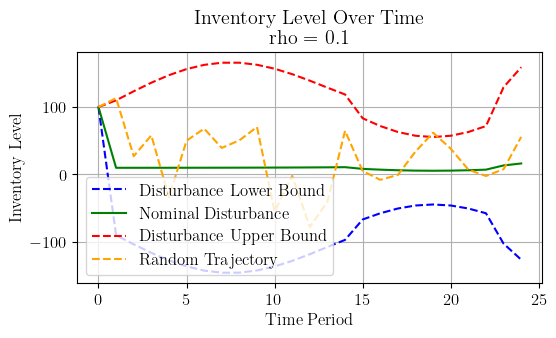

In [286]:
#if y and u are not adjustable
low_values = [x_init.value]
mid_values = [x_init.value]
high_values = [x_init.value]
random_values = [x_init.value]
for i in range(1, T + 1):
    low = (cp.sum((qval+qmat@rhs_upper)[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum((qval+qmat@d_star)[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum((qval-qmat@rhs_lower)[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum((qval+qmat@(random_traj.detach().numpy()))[:i]) - cp.sum(random_traj.detach().numpy()[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values, random_values, 0.1)
print(objval-sum(zval),(c[:T].detach().numpy()@(q + q_var@random_traj) + cp.sum(y + y_var@random_traj) + cp.sum(u + u_var@random_traj)).value )

4407.540029102318 4407.540027569292


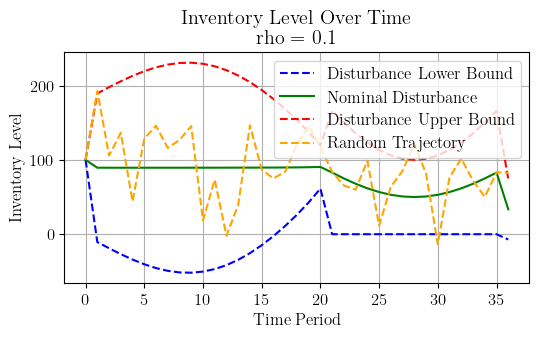

In [7]:
# x_init.value = 100
low_values = [x_init.value]
mid_values = [x_init.value]
high_values = [x_init.value]
random_values = [x_init.value]
for i in range(1, T + 1):
    low = (cp.sum((qval+qmat@rhs_upper)[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum((qval+qmat@d_star)[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum((qval-qmat@rhs_lower)[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum((qval+qmat@(random_traj.detach().numpy()))[:i]) - cp.sum(random_traj.detach().numpy()[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values, random_values, 0.1)
print(objval-sum(zval),(c[:T].detach().numpy()@(q + q_var@random_traj) + cp.sum(y + y_var@random_traj) + cp.sum(u + u_var@random_traj)).value)

In [8]:
wval.round(3) - (qval + qmat@d_star).round(3),np.sum(d_star),np.sum(qval + qmat@d_star),np.sum(wval), np.sum(yval + ymat@d_star), np.sum(uval + umat@d_star),np.sum(zval)

(array([ -989.443, -1086.825, -1171.011, -1250.001, -1321.396, -1383.025,
        -1433.016, -1469.852, -1492.411, -1500.01 , -1492.417, -1469.865,
        -1433.038, -1383.056, -1321.44 , -1250.064, -1171.102, -1086.96 ,
        -1000.217,  -913.567,  -821.375,  -742.101,  -671.467,  -610.815,
         -561.988,  -526.47 ,  -505.34 ,  -499.24 ,  -508.356,  -532.409,
         -570.671,  -621.977,  -684.769,  -757.139,  -836.889,  -863.719]),
 36000.0,
 35933.44200473894,
 0.0,
 363.4325240559492,
 0.0002758698207045922,
 0.0)

## Multistage

In [9]:
d = lropt.UncertainParameter(K,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1,c = -np.eye(K), d = -np.zeros(K), data = np.zeros((1,K))))
# d = lropt.UncertainParameter(K,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1,c = lhs, d = rhs, data = np.zeros((1,K))))
# d = lropt.UncertainParameter(K,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1,c = -np.eye(K), d = np.zeros(K), a = cov[:K,:K], b = d_star[:K]))

y_endind = 2*T+1+K

x_hat = cp.Parameter(T+1)
q_hat = cp.Parameter(T)
d_hat =  cp.Parameter(T)
y_hat = cp.Parameter(T)
u_hat = cp.Parameter(T)
p_xhat = cp.Parameter(K)
h_xhat = cp.Parameter(K)
w = cp.Parameter(K)
t = cp.Parameter(1)
e_ind = cp.Parameter((K,K))
p_ind = cp.Parameter((K,K))
h_ind =  cp.Parameter((K,K))
c_ind = cp.Parameter(K)
d_star_val = cp.Parameter(K)

all_params = [x_hat, q_hat, d_star_val,d_hat, y_hat, u_hat, p_xhat, h_xhat, w, t, e_ind, p_ind, h_ind,c_ind]

e_inds = cp.sum([e_ind[j] for j in range(K)]) #t...t+K
I_inds = cp.diag(e_inds)

uall = cp.Variable(3*K)
q = uall[:K]
y = uall[K:2*K]
u = uall[2*K:3*K]

e_indvar = cp.Variable((K,K))
h_indvar = cp.Variable((K,K))
p_indvar = cp.Variable((K,K))

objective = c_ind@q + e_inds@y + e_inds@u
# constraints = [cp.sum(cp.hstack([param.flatten() for param in all_params])) >= 0]
constraints = [t >= 0, y_hat>=0, u_hat>=0, d_star_val>=0]
constraints += [0 <= q]
constraints += [q <= Qmax]
for i in range(K):
    constraints += [Vmin <= x_hat[0] + cp.sum(q_hat) + cp.sum([e_ind[j] for j in range(i+1)])@q - cp.sum(d_hat) - cp.sum([e_indvar[j] for j in range(i+1)])@d] 

    constraints += [x_hat[0] + cp.sum(q_hat) + cp.sum([e_ind[j] for j in range(i+1)])@q - cp.sum(d_hat) - cp.sum([e_indvar[j] for j in range(i+1)])@d <= Vmax]
    
    constraints += [y[i] >= h_xhat[i] + h_ind[i]@q - h_indvar[i]@d ]

    constraints += [y[i] >= -p_xhat[i] - p_ind[i]@q + p_indvar[i]@d ]

constraints += [u >= alpha1*(q - w),
                u >= alpha2*(w - q )]
constraints += [e_ind == e_indvar, h_ind ==h_indvar, p_ind == p_indvar]
                                                                         
prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
trainer = lropt.Trainer(prob)
policy = trainer.create_cvxpylayer(parameters = all_params, variables = [uall])

In [10]:
# for times in range(T):
#     print(times)
#     prob.solve(verbose=True, solver = cp.CLARABEL)
#     newx = simulator.simulate(torch.tensor(xall.value).repeat(2,1),torch.tensor(uall.value).repeat(2,1))
#     xall.value = newx[0].detach().numpy()

# init_x0 = simulator.init_state(seed = 0, batch_size = 2)
# for i in range(len(all_params)):
#   all_params[i].value = init_x0[i][0].data

# for times in range(T):
#     prob.solve(verbose = True, solver = cp.CLARABEL)
#     newx = simulator.simulate(init_x0,torch.tensor(uall.value).repeat(2,1))
#     for i in range(len(all_params)):
#         all_params[i].value = newx[i][0].data
# #     xall.value = newx[0].detach().numpy()

In [11]:
class InvSimulator(lropt.Simulator):
    def simulate(self, x, u):
        x_hat, q_hat,d_star_val, d_hat, y_hat, u_hat, p_xhat, h_xhat, w, tval, e_ind, p_ind, h_ind,c_ind = x
        t = int(tval[0])
        assert x_hat.shape[0] == u.shape[0]
        batch_size = x_hat.shape[0] 
        demand = demand_dist.sample((batch_size,))[:,t]
        x_orig = x_hat[:,t]
        q_newest = u[:,0]
        q_hat[:,t] = q_newest
        d_hat[:,t] = demand
        d_star_val = d_star_cat[t+1:t+K+1].repeat(batch_size,1)
        x_hat[:,t+1] = x_orig + q_newest - demand
        y_hat[:,t] = u[:,K]
        u_hat[:,t] = u[:,2*K]
        t_new = tval+1
        e_new = eye_concat[t:t+K,t:t+K]
        w_new = w_tch[t:t+K].repeat(batch_size,1)
        t = T-2 if t==T-1 else t
        p_x = torch.vstack([p[t+i+1]*x_hat[:,t+1] for i in range(K)]).T
        h_x = torch.vstack([h[t+i+1]*x_hat[:,t+1] for i in range(K)]).T
        p_new = torch.vstack([p[t+j+1]*np.sum([e_new[i] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1,1)
        h_new = torch.vstack([h[t+j+1]*np.sum([e_new[i] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1,1)
        c_new = (c[t:t+K]*np.sum([e_new[i] for i in range(K)],axis=0)).repeat((batch_size,1))
        e_new = torch.tensor(e_new).repeat(batch_size,1,1)
        x = [x_hat, q_hat, d_star_val,d_hat, y_hat, u_hat,p_x,h_x,w_new,t_new,e_new,p_new,h_new,c_new]
        # print(x)
        return x

    def stage_cost_eval(self,x,u):
        x_hat, q_hat, d_star_val,d_hat, y_hat, u_hat, p_xhat, h_xhat, w, t, e_ind, p_ind, h_ind,c_ind = x
        assert x_hat.shape[0] == u.shape[0]
        t = int(t[0])
        x_hat = x_hat[:,t]
        batch_size = x_hat.shape[0] 
        # return (torch.sum(c[:T].repeat((batch_size,1))*q_hat,axis=1) + torch.sum(y_hat,axis=1)+torch.sum(u_hat,axis=1))
        return T*(c[t-1]*q_hat[:,t-1] + torch.max(-p[t-1]*x_hat, h[t-1]*x_hat) + u_hat[:,t-1])


    def stage_cost(self,x,u):
        x_hat, q_hat, d_star_val,d_hat, y_hat, u_hat, p_xhat, h_xhat, w, t, e_ind, p_ind, h_ind,c_ind = x
        assert x_hat.shape[0] == u.shape[0]
        batch_size = x_hat.shape[0] 
        return (torch.sum(c[:T].repeat((batch_size,1))*q_hat,axis=1) + torch.sum(y_hat,axis=1)+torch.sum(u_hat,axis=1))


    def constraint_cost(self,x,u,alpha):
        eta = 0.05
        x_hat, q_hat,  d_star_val,d_hat, y_hat, u_hat, p_xhat, h_xhat, w, t, e_ind, p_ind, h_ind,c_ind = x
        t = int(t[0])
        x_hat = x_hat[:,t]
        y_hat = y_hat[:,t-1]
        assert x_hat.shape[0] == u.shape[0]
        batch_size = x_hat.shape[0] 
        cvar_term =(1/eta)*torch.max(torch.max(-p[t-1]*x_hat, h[t-1]*x_hat) - y_hat - alpha,torch.zeros(batch_size)) + alpha
        return (cvar_term + 0.01)

    def init_state(self,batch_size, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        t = 0
        x_new = torch.zeros((batch_size,T+1))
        x_orig = 100*torch.ones((batch_size,))
        w_new = w_tch[t:t+K].repeat((batch_size,1))
        x_new[:,0] = x_orig
        q_new = torch.zeros((batch_size,T))
        d_star_val = d_star_cat[t:t+K].repeat(batch_size,1)
        d_new = torch.zeros((batch_size,T))
        y_new = torch.zeros((batch_size,T))
        u_new = torch.zeros((batch_size,T))
        p_x = torch.vstack([p[t+i]*x_new[:,t] for i in range(K)]).T
        h_x = torch.vstack([h[t+i]*x_new[:,t] for i in range(K)]).T
        t_new = (torch.tensor(t,dtype=torch.double)).repeat(batch_size,1)
        e_new = eye_concat[t:t+K,t:t+K]
        p_new = torch.vstack([p[t+j]*np.sum([e_new[i] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1,1)
        h_new = torch.vstack([h[t+j]*np.sum([e_new[i] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1,1)
        c_new = (c[t:t+K]*np.sum([e_new[i] for i in range(K)],axis=0)).repeat((batch_size,1))
        e_new = torch.tensor(e_new).repeat(batch_size,1,1)
        x = [x_new,q_new,d_star_val,d_new,y_new,u_new,p_x,h_x,w_new,t_new,e_new,p_new,h_new,c_new]
        return x
simulator = InvSimulator()

In [22]:
# Perform training
epochs = 201
batch_size = 5
test_batch_size = 5
lr = 0.00000001

# init_x0 = simulator.init_state(seed = 0, batch_size = 100)
init_a = cov[:K,:K]
init_b = np.zeros(K)
# init_b = d_star[:K]
init_weights = torch.zeros((K*K+K,y_endind))
init_weights[K*K:,2*T+1:] = torch.eye(K)
val_costs1, val_costs_constr1, \
  paramvals, x_base1, u_base1, \
    train_vals1, train_cons1 = trainer.multistage_train(simulator, 
                                                       policy = policy, 
                         time_horizon = T, epochs = epochs, 
                         batch_size = batch_size, init_eps=2, seed=0,
                          init_a = init_a, init_b = init_b,
                          optimizer = "SGD",lr= lr, momentum = 0, init_alpha = 0.0, scheduler = True, lr_step_size = 20, lr_gamma = 0.5, contextual = True, test_batch_size = test_batch_size,y_endind = y_endind, init_weight=init_weights, init_lam = 0.001, init_mu = 0.01, mu_multiplier = 1.01)

Baseline cost:  4269.248004191888
epoch 0, valid 4.2671e+03, vio 2.0986e+00
epoch 20, valid 4.2667e+03, vio 2.6287e+00
epoch 40, valid 4.2664e+03, vio 2.9011e+00
epoch 60, valid 4.2663e+03, vio 3.0268e+00
epoch 80, valid 4.2663e+03, vio 3.0907e+00
epoch 100, valid 4.2663e+03, vio 3.1221e+00
epoch 120, valid 4.2663e+03, vio 3.1377e+00
epoch 140, valid 4.2662e+03, vio 3.1458e+00
epoch 160, valid 4.2662e+03, vio 3.1498e+00
epoch 180, valid 4.2662e+03, vio 3.1517e+00
epoch 200, valid 4.2662e+03, vio 3.1527e+00


In [404]:
trainer._eps_tch, trainer._alpha, trainer._a_tch, trainer._b_tch

(tensor(-9.6265), tensor(-1.2333), None, None)

In [405]:
trainer._linear.weight.data, trainer._linear.bias.data

(tensor([[ 1.3517e-05,  1.5301e-06, -2.0788e-05,  ..., -7.1427e-06,
          -2.3464e-05, -2.0830e-05],
         [-5.6056e-05, -6.5514e-06,  5.1378e-05,  ..., -5.0409e-04,
          -5.0341e-04, -5.0988e-04],
         [-3.6434e-05, -4.3036e-06,  3.3401e-05,  ..., -3.3563e-04,
          -3.3726e-04, -3.4510e-04],
         ...,
         [ 5.8810e-05,  6.8667e-06, -6.0030e-05,  ...,  1.0004e+00,
           4.2822e-04,  4.2405e-04],
         [ 3.7870e-05,  4.4634e-06, -4.0773e-05,  ...,  2.7125e-04,
           1.0003e+00,  2.5688e-04],
         [ 2.3715e-05,  2.7650e-06, -2.9644e-05,  ...,  1.4942e-04,
           1.3683e-04,  1.0001e+00]]),
 tensor([ 4.4721e+01, -5.6056e-07, -3.6434e-07, -2.3759e-07, -6.0567e-07,
          4.4721e+01, -2.3151e-07, -1.4226e-07, -2.7796e-07, -9.2064e-08,
          4.4721e+01, -1.3325e-07,  1.5627e-08,  1.6673e-07,  4.3514e-08,
          4.4721e+01, -1.1419e-06,  5.8810e-07,  3.7870e-07,  2.3715e-07]))

In [23]:
def plot_iters(val_costs1,val_costs_constr1,epochs):
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.plot(np.arange(0,epochs,20), (np.array(val_costs1)), c='k', label=r"$\hat{J}(\theta)$")
    ax1 = ax.twinx()
    ax1.plot(np.arange(0,epochs,20),(np.array(val_costs_constr1)), color = 'red', 
    linestyle = "-", label = r"$\hat{V}(\theta)$")
    ax1.hlines(y=0,xmin=0,xmax=epochs, color= "black", linestyle = "--", label = "0")
    # plt.ylim([-0.03,0.015])
    ax.set_xlabel('iteration')
    ax.set_ylabel('cost')
    fig.tight_layout()
    plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
    ax.legend(fontsize = 15)
    plt.savefig("port_iters.pdf", bbox_inches='tight')
    plt.show()
def plot_states(x_base1,indval=0):
    plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":12,
    "font.family": "serif"
    })

    fig,ax= plt.subplots(1,4, figsize = (10,2.5))
    for i in range(1):
        ax[0].plot(x_base1[indval][0][-1][0][i]) # x
        ax[1].plot(c[:T]*x_base1[indval][0][-1][1][i], label = "Dynamic RO ($K=1$)") # q
        ax[2].plot(np.maximum(h[:T]*x_base1[indval][0][-1][0][i][1:], -p[:T]*x_base1[indval][0][-1][0][i][1:]))
        # ax[2].plot(x_base1[indval][0][-1][4][i]) # y
        # ax[3].plot(x_base1[indval][0][-1][5][i]) # u
        ax[3].plot(np.cumsum(c[:T]*x_base1[indval][0][-1][1][i]+np.maximum(h[:T]*x_base1[indval][0][-1][0][i][1:], -p[:T]*x_base1[indval][0][-1][0][i][1:]))/ np.cumsum(c[:T]*(qval+qmat@random_traj.detach().numpy()) + np.maximum(h[:T]*np.array(random_values[1:]), -p[:T]*np.array(random_values[1:]))))

    # ax[0].plot(np.mean(x_base1[indval][0][-1][0],axis=0))
    # ax[1].plot(np.mean(c[:T].detach().numpy()*x_base1[indval][0][-1][1],axis=0), label = "Dynamic ARO")
    # ax[2].plot(np.mean([np.maximum(h[:T]*x_base1[indval][0][-1][0][i][1:], -p[:T]*x_base1[indval][0][-1][0][i][1:]) for i in range(5)],axis=0))
    # ax[3].plot(np.mean([np.cumsum(c[:T]*x_base1[indval][0][-1][1][i]+np.maximum(h[:T]*x_base1[indval][0][-1][0][i][1:], -p[:T]*x_base1[indval][0][-1][0][i][1:])) for i in range(5)],axis = 0))

    ax[0].plot(random_values, color = 'black')
    ax[1].plot(c[:T]*(qval+qmat@random_traj.detach().numpy()), color = 'black',label="ARO")
    ax[2].plot(np.maximum(h[:T]*np.array(random_values[1:]), -p[:T]*np.array(random_values[1:])), color = 'black')
    ax[3].plot(np.cumsum(c[:T]*(qval+qmat@random_traj.detach().numpy()) + np.maximum(h[:T]*np.array(random_values[1:]), -p[:T]*np.array(random_values[1:])))/np.cumsum(c[:T]*(qval+qmat@random_traj.detach().numpy()) + np.maximum(h[:T]*np.array(random_values[1:]), -p[:T]*np.array(random_values[1:]))), color = 'black')
    # ax[3].plot(uval+umat@random_traj.detach().numpy(), color = 'black')
    ax[0].plot(random_values1, color = 'black',linestyle = "--")
    ax[1].plot(c[:T]*qval1, color = 'black',label="RO",linestyle = "--")
    ax[2].plot(np.maximum(h[:T]*np.array(random_values1[1:]), -p[:T]*np.array(random_values1[1:])), color = 'black',linestyle = "--")
    ax[3].plot(np.cumsum(c[:T]*qval1 +np.maximum(h[:T]*np.array(random_values1[1:]), -p[:T]*np.array(random_values1[1:])))/np.cumsum(c[:T]*(qval+qmat@random_traj.detach().numpy()) + np.maximum(h[:T]*np.array(random_values[1:]), -p[:T]*np.array(random_values[1:]))), color = 'black',linestyle = "--")
    # ax[3].plot(uval1, color = 'black',linestyle = "--")
    for i in range(4):
        ax[i].grid(True)
        ax[i].set_xlabel('Time Period')
    ax[0].set_title('Inventory Level')
    ax[1].set_title('Ordering Cost')
    ax[2].set_title('Holding/Shortage Cost')
    ax[3].set_title(r'Cumulative Cost (\% of ARO)')
    # ax[3].set_title('Commitment Deviation Cost')
    fig.tight_layout()
    ax[1].legend(bbox_to_anchor=(1, -0.3))
    plt.savefig("port_comps.pdf", bbox_inches='tight')
    plt.show()


### K=4

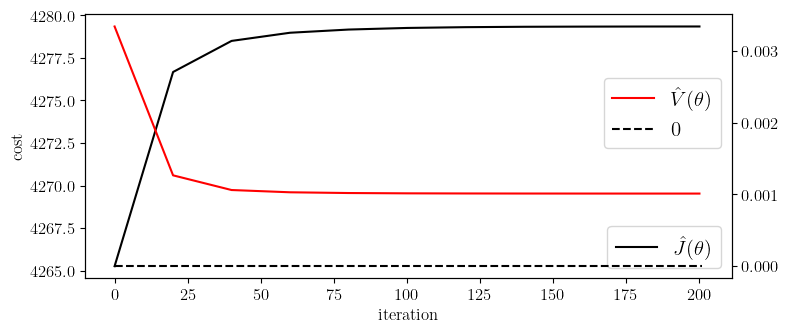

In [25]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.5/20, init 0.0000001,5/5 batch, eps2, cvar 0.001,0.01, seed 0, clarabel, context, p=c2 h=c1, T=12,K=4

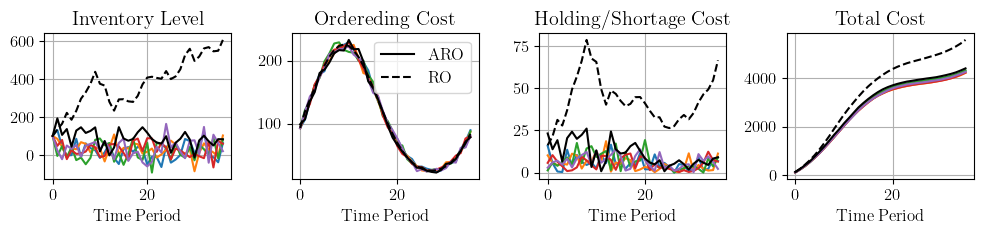

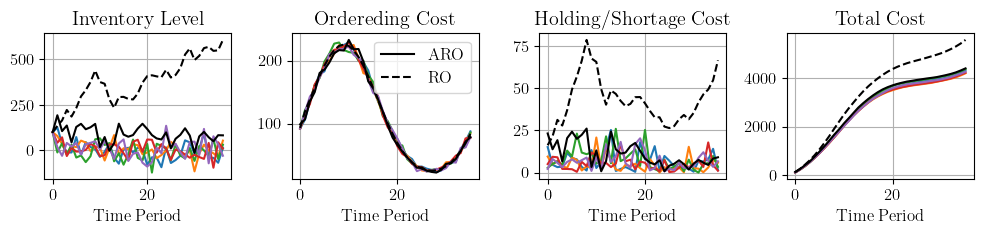

In [26]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

### K=1

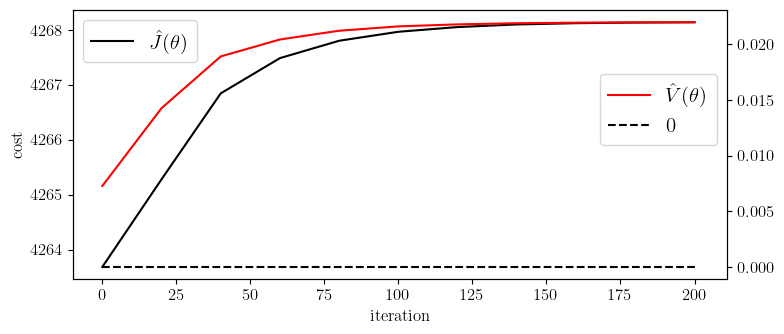

In [39]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.5/20, init 0.0000001,5/5 batch, eps1.5, cvar 0.001,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=1

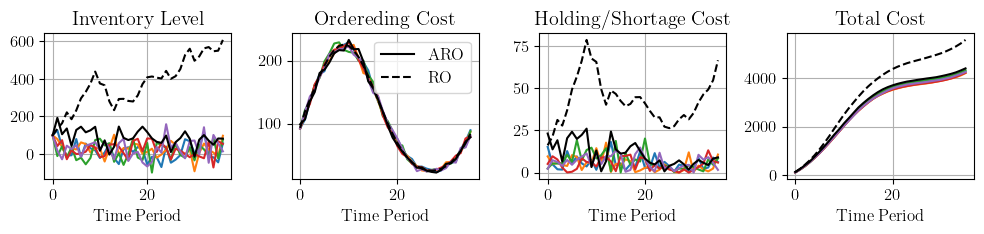

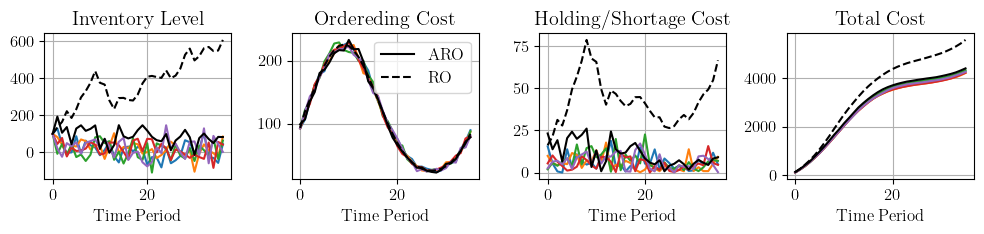

In [38]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

python(73924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


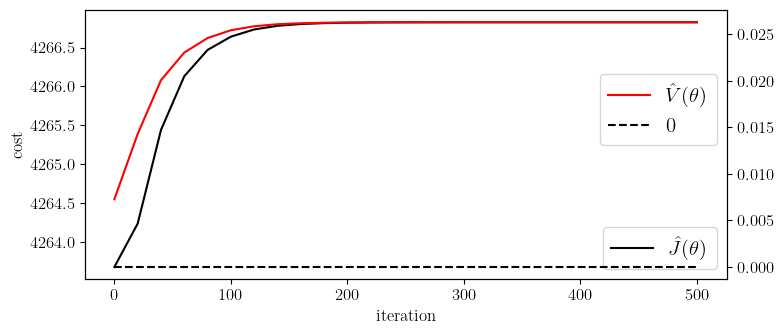

In [14]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.5/20, init 0.001,5/5 batch, eps1.5, cvar 0.001,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=12, no weight train

python(88124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


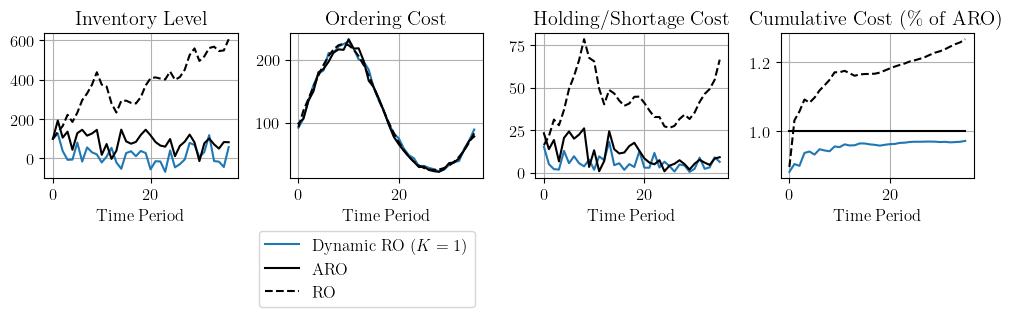

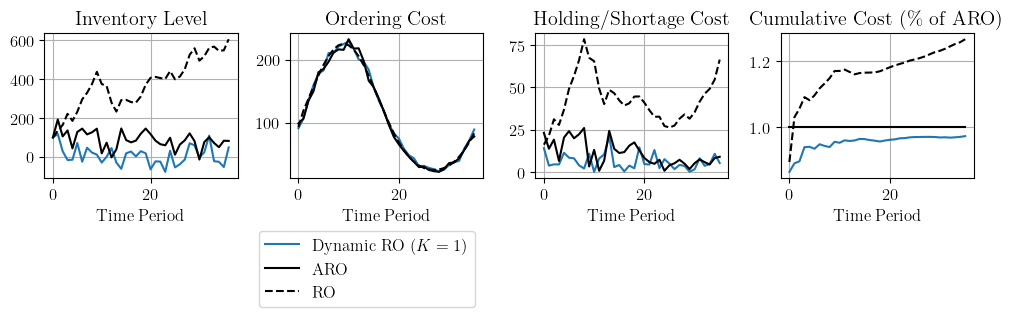

In [22]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

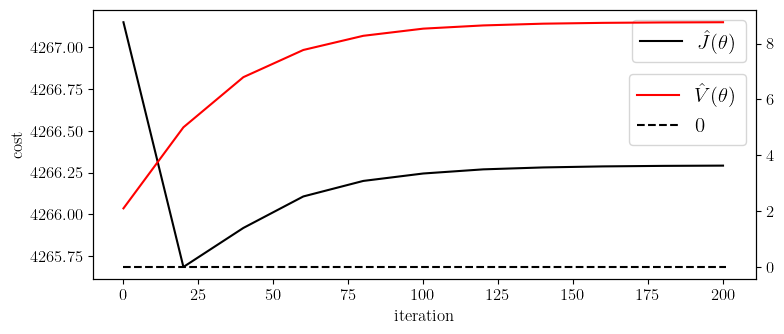

In [20]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.5/20, init 0.00000005,5/5 batch, eps2, cvar 0.001,0.001,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=12, aug_lag

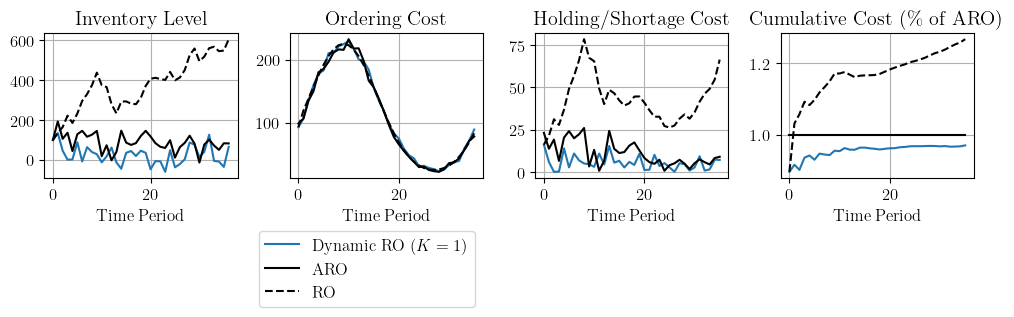

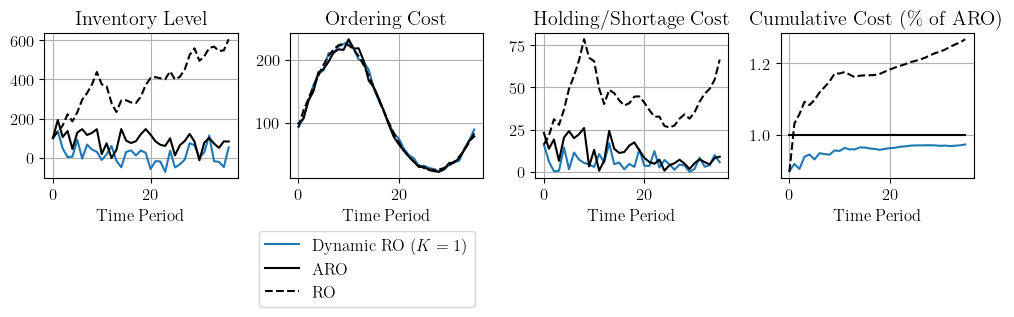

In [19]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

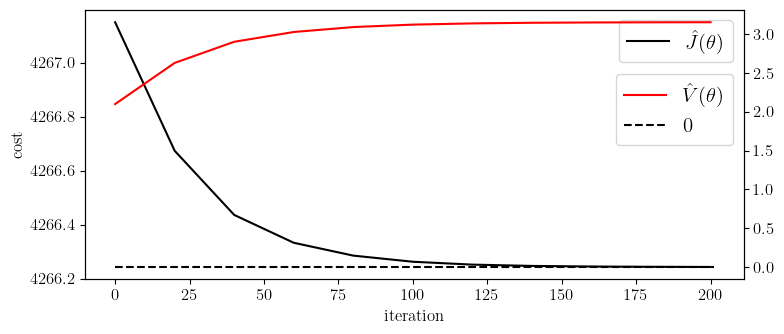

In [26]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.5/20, init 0.00000001,5/5 batch, eps2, cvar 0.001,0.01,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=12, aug_lag

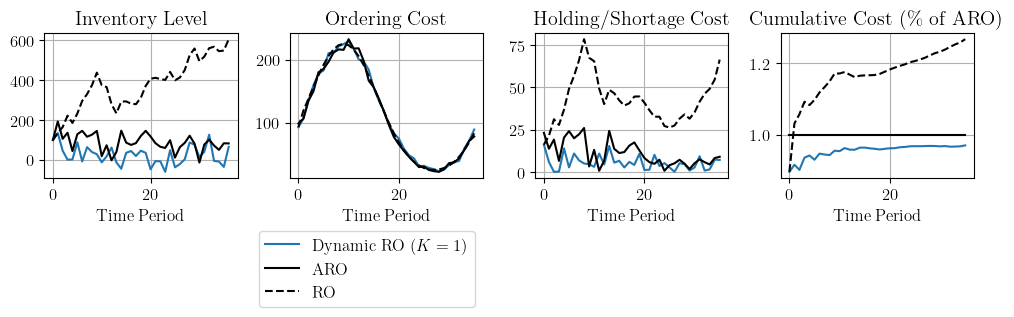

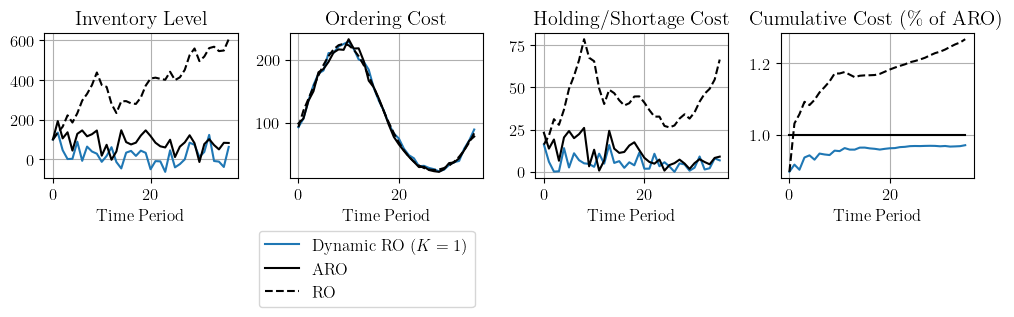

In [27]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)